In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
class MyRFECV(object):
    
    def __init__(self, estimator, step, cv, features):
        self.estimator = estimator
        self.step = step
        self.cv = cv
        self.features = features
        
    def _score(self, labels, probs):
        
        names = ['b', 'c', 'sud', 'gluon']
        roc_auc = utils.get_roc_auc_matrix(labels, probs, names, save_path=None, show=False)
        return roc_auc.values.mean()
        
    def _fit_step(self, data, features):
        sk = SklearnClassifier(self.estimator, features=None)
        folding = FoldingClassifier(sk, n_folds=self.cv, random_state=11, features=features)
        folding.fit_lds(data)
        importances = folding.feature_importances_
        indices = numpy.argsort(importances)[::-1]
        
        labels = data.target
        probs = folding.predict_proba(data.data)
        score = self._score(labels, probs)
        
        return features[indices], score
        
    def fit(self, data):
        features = self.features
        feature_list = []
        score_list = []
        
        while len(features) >= self.step:
            features, score = self._fit_step(data, features)
            feature_list.append(features)
            score_list.append(score)
            
            features = features[:-self.step]
            
        if len(features) > 0:
            features, score = self._fit_step(data, features)
            feature_list.append(features)
            score_list.append(score)
            
        return numpy.array(feature_list), numpy.array(score_list)

In [3]:
%matplotlib inline
import root_numpy
import pandas
import numpy
import matplotlib.pyplot as plt
from rep.data import LabeledDataStorage
#from hep_ml.decisiontrain import DecisionTrainClassifier, DecisionTrainRegressor
from hep_ml.losses import LogLossFunction, MSELossFunction
from rep.metaml import FoldingClassifier, FoldingRegressor
from rep.report import ClassificationReport
from rep.report.metrics import RocAuc
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, ExtraTreesClassifier
from rep.estimators import XGBoostClassifier, SklearnClassifier
import cPickle as pickle

## Read data

In [4]:
treename = 'tag'

data_b = pandas.DataFrame(root_numpy.root2array('/home/mikhail91/jet_tagging_LHCb/datasets/type=5.root', treename=treename)).dropna()
data_b = data_b[::90]
data_c = pandas.DataFrame(root_numpy.root2array('/home/mikhail91/jet_tagging_LHCb/datasets/type=4.root', treename=treename)).dropna()
data_light = pandas.DataFrame(root_numpy.root2array('/home/mikhail91/jet_tagging_LHCb/datasets/type=0.root', treename=treename)).dropna()
data_light = data_light[::2]

In [5]:
data = {'b': data_b, 'c': data_c, 'light': data_light}

In [6]:
full_data = pandas.concat([data_b, 
                           data_c, 
                           data_light[data_light.JetParton != 0], 
                           data_light[data_light.JetParton == 0]])

full_data['label'] = [0] * len(data_b) + \
                     [1] * len(data_c) + \
                     [2] * len(data_light[data_light.JetParton != 0]) + \
                     [3] * len(data_light[data_light.JetParton == 0])

In [7]:
names = ['b', 'c', 'sud', 'gluon']

In [8]:
jet_features = [column for column in data_b.columns if "Jet" in column]
sv_features = [column for column in data_b.columns if "SV" in column]

# Multiclassification

## Data preprocessing

In [9]:
train_data = full_data[sv_features].values
labels = full_data['label'].values

## Train

In [10]:
from rep.estimators import XGBoostClassifier
xgb_base = XGBoostClassifier(n_estimators=1000, colsample=0.7, eta=0.01, nthreads=8, 
                             subsample=0.5, max_depth=8)
# xgb_base = RandomForestClassifier(n_estimators=100, max_depth=None, max_features='auto')
multi_folding = FoldingClassifier(xgb_base, n_folds=2, random_state=11)
%time multi_folding.fit(train_data, labels)

CPU times: user 9min 56s, sys: 760 ms, total: 9min 56s
Wall time: 1min 15s


FoldingClassifier(base_estimator=XGBoostClassifier(base_score=0.5, colsample=0.7, eta=0.01, features=None,
         gamma=None, max_depth=8, min_child_weight=1.0, missing=-999.0,
         n_estimators=1000, nthreads=8, num_feature=None, random_state=0,
         scale_pos_weight=1.0, subsample=0.5, verbose=0),
         features=['Feature_0', 'Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8'],
         n_folds=2, parallel_profile=None, random_state=11)

In [11]:
multi_probs = multi_folding.predict_proba(train_data)

KFold prediction using folds column


## Results

In [12]:
import os, sys
sys.path.append('python')
import utils

In [13]:
from sklearn.metrics import log_loss

print 'Log loss is ', log_loss(labels, multi_probs)

Log loss is  0.59563031774


In [14]:
def get_learning_curve(clf, data, labels):

    n_estimators = clf.get_params()['base_estimator__n_estimators']
    staged_probas = clf.staged_predict_proba(data)

    from sklearn.metrics import log_loss
    log_loss_all = []
    for pred in staged_probas:
        log_loss_all.append(log_loss(labels, pred))

    x = numpy.arange(10, n_estimators + 10, 10)
    plt.plot(x, log_loss_all)
    plt.ylabel('Log loss')
    plt.xlabel('Iteration')
    plt.show()

KFold prediction using folds column


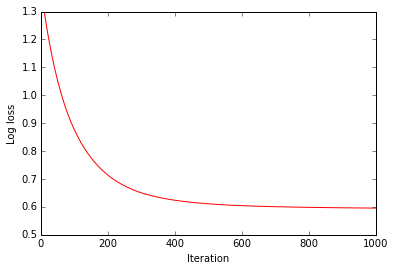

In [15]:
get_learning_curve(multi_folding, train_data, labels)

/moosefs/miniconda/envs/ipython_py2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


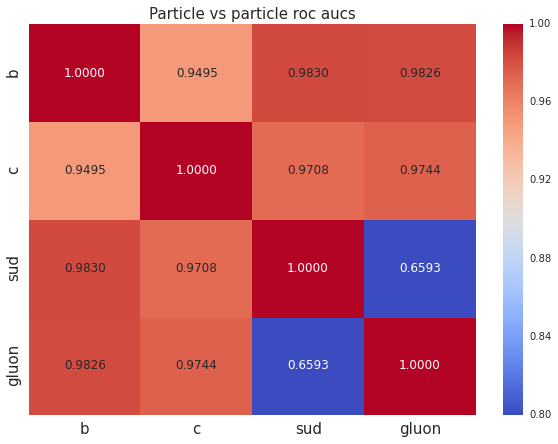

,b,c,sud,gluon
b,1.000000,0.949465,0.983033,0.982559
c,0.949465,1.000000,0.970798,0.974356
sud,0.983033,0.970798,1.000000,0.659258
gluon,0.982559,0.974356,0.659258,1.000000


In [15]:
roc_auc_baseline = utils.get_roc_auc_matrix(labels, multi_probs, names, save_path=None, show=True)
roc_auc_baseline

# Simple classifiers as features

# KNearest

In [16]:
from sklearn.metrics import mean_absolute_error
from sklearn.base import clone
from rep.metaml import GridOptimalSearchCV, FoldingScorer, RandomParameterOptimizer
from sklearn.metrics import log_loss

class MyMeanRocAucScorer(object):
    def __init__(self, X_test, y_test):
        self.X_test = X_test
        self.y_test = y_test
        
    def __call__(self, estimator, X, y):
        cl = clone(estimator)
        cl.fit(X, y)
        logloss = -log_loss(self.y_test, cl.predict_proba(self.X_test))
        return logloss

In [17]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()
mms.fit(train_data)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [61]:
from sklearn.grid_search import GridSearchCV
from rep.utils import train_test_split
from sklearn.neighbors import KNeighborsClassifier

train_train_data, test_data, train_labels, test_labels = train_test_split(train_data, labels, test_size=0.3)

grid_param = {}
grid_param['n_neighbors'] = [1, 5, 10, 20, 50, 100, 200, 500, 1000]
grid_param['leaf_size'] = [10, 30, 50, 100]
grid_param['weights'] = ['uniform', 'distance']

knn = KNeighborsClassifier(n_neighbors=5, algorithm='auto', leaf_size=30, n_jobs=8)

grid = GridSearchCV(estimator=knn, param_grid=grid_param, cv=2, 
                    scoring=MyMeanRocAucScorer(mms.transform(test_data), test_labels), n_jobs=8)
grid.fit(mms.transform(train_train_data), train_labels)

GridSearchCV(cv=2, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=8, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=8,
       param_grid={'n_neighbors': [1, 5, 10, 20, 50, 100, 200, 500, 1000], 'weights': ['uniform', 'distance'], 'leaf_size': [10, 30, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=<__main__.MyMeanRocAucScorer object at 0x7f7334a0ec90>,
       verbose=0)

In [63]:
grid.best_params_

{'leaf_size': 10, 'n_neighbors': 200, 'weights': 'distance'}

In [64]:
grid.best_score_

-0.85128545183067827

In [66]:
from sklearn.neighbors import KNeighborsClassifier

knn = SklearnClassifier(KNeighborsClassifier(n_neighbors=200, algorithm='auto', leaf_size=10, n_jobs=8))

knn_folding = FoldingClassifier(knn, n_folds=2, random_state=11)
%time knn_folding.fit(mms.transform(train_data), labels)

CPU times: user 608 ms, sys: 12 ms, total: 620 ms
Wall time: 620 ms


FoldingClassifier(base_estimator=SklearnClassifier(clf=KNeighborsClassifier(algorithm='auto', leaf_size=10, metric='minkowski',
           metric_params=None, n_jobs=8, n_neighbors=200, p=2,
           weights='uniform'),
         features=None),
         features=['Feature_0', 'Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8'],
         n_folds=2, parallel_profile=None, random_state=11)

In [67]:
knn_probs = knn_folding.predict_proba(mms.transform(train_data))

KFold prediction using folds column


## Train

In [73]:
from rep.estimators import XGBoostClassifier
xgb_base = XGBoostClassifier(n_estimators=1000, colsample=0.7, eta=0.01, nthreads=8, 
                             subsample=0.5, max_depth=8)
# xgb_base = RandomForestClassifier(n_estimators=100, max_depth=None, max_features='auto')
knn_multi_folding = FoldingClassifier(xgb_base, n_folds=2, random_state=11)
%time knn_multi_folding.fit(numpy.concatenate((train_data, knn_probs), axis=1), labels)

CPU times: user 10min 52s, sys: 732 ms, total: 10min 53s
Wall time: 1min 22s


FoldingClassifier(base_estimator=XGBoostClassifier(base_score=0.5, colsample=0.7, eta=0.01, features=None,
         gamma=None, max_depth=8, min_child_weight=1.0, missing=-999.0,
         n_estimators=1000, nthreads=8, num_feature=None, random_state=0,
         scale_pos_weight=1.0, subsample=0.5, verbose=0),
         features=['Feature_0', 'Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8', 'Feature_9', 'Feature_10', 'Feature_11', 'Feature_12'],
         n_folds=2, parallel_profile=None, random_state=11)

In [76]:
knn_multi_probs = knn_multi_folding.predict_proba(numpy.concatenate((train_data, knn_probs), axis=1))

KFold prediction using folds column


In [84]:
knn_multi_folding.get_feature_importances()

,effect
Feature_0,0.922721
Feature_1,1.000000
Feature_2,0.873090
Feature_3,0.863507
Feature_4,0.772573
Feature_5,0.071587
Feature_6,0.096142
Feature_7,0.963200
Feature_8,0.919957
Feature_9,0.522788


## Results

In [77]:
from sklearn.metrics import log_loss

print 'Log loss is ', log_loss(labels, knn_multi_probs)

Log loss is  0.597662466192


KFold prediction using folds column


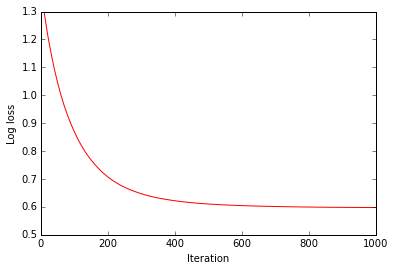

In [82]:
get_learning_curve(knn_multi_folding, numpy.concatenate((train_data, knn_probs), axis=1), labels)

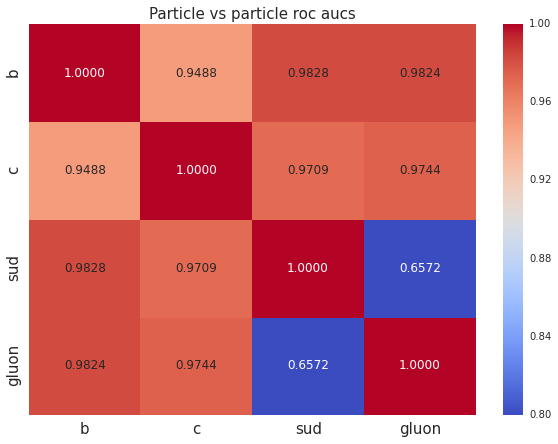

,b,c,sud,gluon
b,1.000000,0.948805,0.982795,0.982404
c,0.948805,1.000000,0.970890,0.974407
sud,0.982795,0.970890,1.000000,0.657184
gluon,0.982404,0.974407,0.657184,1.000000


In [80]:
knn_roc_aucs = utils.get_roc_auc_matrix(labels, knn_multi_probs, names, save_path=None, show=True)
knn_roc_aucs

In [81]:
knn_roc_aucs - roc_auc_baseline

,b,c,sud,gluon
b,0.000000,-0.000660,-0.000239,-0.000155
c,-0.000660,0.000000,0.000092,0.000051
sud,-0.000239,0.000092,0.000000,-0.002073
gluon,-0.000155,0.000051,-0.002073,0.000000


# SVM

In [34]:
from sklearn.grid_search import GridSearchCV
from rep.utils import train_test_split
from sklearn.svm import SVC

train_train_data, test_data, train_labels, test_labels = train_test_split(train_data, labels, test_size=0.3)

grid_param = {}
grid_param['C'] = [1, 0.1, 10, 100]
grid_param['kernel'] = ['rbf', 'poly', 'sigmoid']
grid_param['degree'] = [3, 5, 7]
grid_param['gamma'] = ['auto', 1, 10]
grid_param['coef0'] = [0.0, 1, 10]


svc = SVC(max_iter=100, class_weight='balanced', probability=True)

grid_svc = GridSearchCV(estimator=svc, param_grid=grid_param, cv=2, 
                    scoring=MyMeanRocAucScorer(mms.transform(test_data), test_labels), n_jobs=8)
grid_svc.fit(mms.transform(train_train_data), train_labels)

GridSearchCV(cv=2, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=100, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=8,
       param_grid={'kernel': ['rbf', 'poly', 'sigmoid'], 'C': [1, 0.1, 10, 100], 'coef0': [0.0, 1, 10], 'gamma': ['auto', 1, 10], 'degree': [3, 5, 7]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=<__main__.MyMeanRocAucScorer object at 0x7f650a244c50>,
       verbose=0)

In [36]:
grid_svc.best_params_

{'C': 100, 'coef0': 10, 'degree': 7, 'gamma': 1, 'kernel': 'sigmoid'}

In [37]:
grid_svc.best_score_

-1.0992533410472638

In [38]:
from sklearn.neighbors import KNeighborsClassifier

svc = SVC(max_iter=100, class_weight='balanced', probability=True, 
          C=100, coef0=10, degree=7, gamma=1, kernel='sigmoid')

svc_folding = FoldingClassifier(svc, n_folds=2, random_state=11)
%time svc_folding.fit(mms.transform(train_data), labels)

CPU times: user 8.36 s, sys: 4 ms, total: 8.36 s
Wall time: 8.36 s


FoldingClassifier(base_estimator=SVC(C=100, cache_size=200, class_weight='balanced', coef0=10,
  decision_function_shape=None, degree=7, gamma=1, kernel='sigmoid',
  max_iter=100, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
         features=['Feature_0', 'Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8'],
         n_folds=2, parallel_profile=None, random_state=11)

In [39]:
svc_probs = svc_folding.predict_proba(mms.transform(train_data))

KFold prediction using folds column


## Train

In [55]:
from rep.estimators import XGBoostClassifier
xgb_base = XGBoostClassifier(n_estimators=1000, colsample=0.7, eta=0.01, nthreads=8, 
                             subsample=0.5, max_depth=8)
# xgb_base = RandomForestClassifier(n_estimators=100, max_depth=None, max_features='auto')
svc_multi_folding = FoldingClassifier(xgb_base, n_folds=2, random_state=11)
%time svc_multi_folding.fit(numpy.concatenate((train_data, svc_probs), axis=1), labels)

CPU times: user 11min 40s, sys: 752 ms, total: 11min 41s
Wall time: 1min 28s


FoldingClassifier(base_estimator=XGBoostClassifier(base_score=0.5, colsample=0.7, eta=0.01, features=None,
         gamma=None, max_depth=8, min_child_weight=1.0, missing=-999.0,
         n_estimators=1000, nthreads=8, num_feature=None, random_state=0,
         scale_pos_weight=1.0, subsample=0.5, verbose=0),
         features=['Feature_0', 'Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8', 'Feature_9', 'Feature_10', 'Feature_11', 'Feature_12'],
         n_folds=2, parallel_profile=None, random_state=11)

In [56]:
svc_multi_probs = svc_multi_folding.predict_proba(numpy.concatenate((train_data, svc_probs), axis=1))

KFold prediction using folds column


## Results

In [57]:
from sklearn.metrics import log_loss

print 'Log loss is ', log_loss(labels, svc_multi_probs)

Log loss is  0.613427107717


KFold prediction using folds column


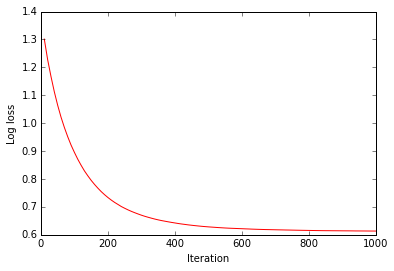

In [43]:
get_learning_curve(svc_multi_folding, numpy.concatenate((train_data, svc_probs), axis=1), labels)

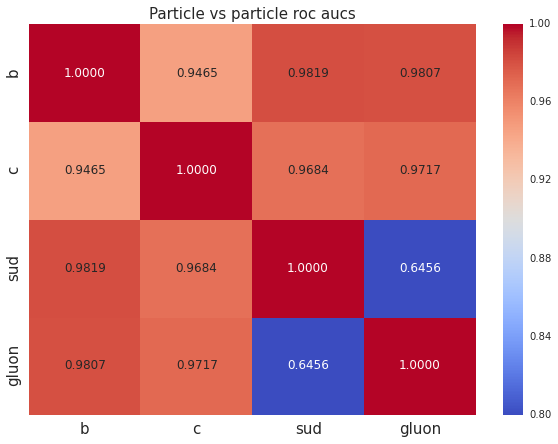

,b,c,sud,gluon
b,1.000000,0.946517,0.981899,0.980650
c,0.946517,1.000000,0.968361,0.971657
sud,0.981899,0.968361,1.000000,0.645601
gluon,0.980650,0.971657,0.645601,1.000000


In [58]:
svc_roc_aucs = utils.get_roc_auc_matrix(labels, svc_multi_probs, names, save_path=None, show=True)
svc_roc_aucs

In [59]:
svc_roc_aucs - roc_auc_baseline

,b,c,sud,gluon
b,0.000000,-0.002948,-0.001135,-0.001909
c,-0.002948,0.000000,-0.002437,-0.002699
sud,-0.001135,-0.002437,0.000000,-0.013656
gluon,-0.001909,-0.002699,-0.013656,0.000000
